<h2><center>Analyzing Location data for suggesting a new Bar - Python Data Science</center></h2>

---

<div class="section-inner sectionLayout--insetColumn">
<h3 name="fdbd" class="graf graf--h3 graf--leading">
<strong class="markup--strong markup--h3-strong">The Business Plan&#8202;—&#8202;Short summary:</strong></h3>
<p name="ca01" class="graf graf--p graf-after--h3">

For this project, I am going to utilize the Foursquare API for referencing
<strong class="markup--strong markup--p-strong">location data in the Boston, MA</strong> area.
This data will allow us to report on and provide feedback to interested parties
<strong class="markup--strong markup--p-strong">looking to open a bar</strong>.</p>


### Getting Started

In [1]:
# import the proper libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
import jmespath

import json # library to handle JSON files
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


#### Download and Explore Dataset

In [2]:
import wget

## GeoJSON Data
# wget.download(
#     'http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson?outSR={%22latestWkid%22:2249,%22wkid%22:102686}',
#     'boston_data.json'
# )

In [3]:
with open('boston-neighborhoods.json') as json_data:
    boston_data = json.load(json_data)

### A Quick look at the map of the GeoJSON datafile on a map using folium

In [4]:
boston_map = folium.Map(location=[42.329143, -71.076449], zoom_start=11)
boston_map.choropleth(
    geo_data=boston_data
)

# display map
boston_map

d:\github\.virtualenvs\coursera\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


Looking at the raw data, the **features** key holds the relevant neighborhood data.

In [5]:
boston_neighborhoods = boston_data['features']

#### Transform the data into a *pandas* dataframe

In [6]:
# define the dataframe columns
# column_names = ['Neighborhood', 'Neighborhood_ID', 'SqMiles','Latitude', 'Longitude']
column_names = ['Neighborhood', 'Neighborhood_Density','Latitude', 'Longitude']

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Let's loop through the data and fill the dataframe one row at a time.

In [7]:
# for data in boston_neighborhoods:
#     neighborhood_name = data['properties']['Name']
#     neighborhood_id = data['properties']['Neighborhood_ID']
#     neighborhood_size = data['properties']['SqMiles']
#     neighborhood_latlon = data['geometry']['coordinates']
#     neighborhood_lat = neighborhood_latlon
#     neighborhood_lon = neighborhood_latlon
#
#     neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
#                                           'Neighborhood_ID': neighborhood_id,
#                                           'SqMiles': neighborhood_size,
#                                           'Latitude': neighborhood_lat,
#                                           'Longitude': neighborhood_lon}, ignore_index=True)
for data in boston_neighborhoods:
    neighborhood_name = data['properties']['Name']
    neighborhood_density = data['properties']['density']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon
    neighborhood_lon = neighborhood_latlon

    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'Neighborhood_Density': neighborhood_density,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [8]:
neighborhoods.head()

,Neighborhood,Neighborhood_Density,Latitude,Longitude
0,Roslindale,5.58,"[[[[-71.12592656722312, 42.27200445346726], [-...","[[[[-71.12592656722312, 42.27200445346726], [-..."
1,Jamaica Plain,7.62,"[[[-71.10499158300003, 42.3260930173557], [-71...","[[[-71.10499158300003, 42.3260930173557], [-71..."
2,Mission Hill,18.24,"[[[-71.09043371458033, 42.33576129552895], [-7...","[[[-71.09043371458033, 42.33576129552895], [-7..."
3,Longwood Medical Area,0.00,"[[[-71.09810833985203, 42.33672170994753], [-7...","[[[-71.09810833985203, 42.33672170994753], [-7..."
4,Bay Village,0.00,"[[[-71.06662865656764, 42.3487740128554], [-71...","[[[-71.06662865656764, 42.3487740128554], [-71..."


Since the data downloaded came in a MultiPolygon geometry feature for the coordinates, we will want to convert
the coordinates to a single Point using the geojson library.

In [9]:
# Query the results you want from the json dataset,
# and in this case we have neighborhoods with different size arrays so multiple queries are needed

query = """
[*].{
Neighborhood: properties.Name,
Neighborhood_Density: properties.density,
Latitude: geometry.coordinates[0][0][0][1],
Longitude: geometry.coordinates[0][0][0][0]
}
"""

query2 = """
[*].{
Neighborhood: properties.Name,
Neighborhood_Density: properties.density,
Latitude: geometry.coordinates[0][0][1],
Longitude: geometry.coordinates[0][0][0]
}
"""

compiled = jmespath.compile(query)
results = compiled.search(boston_neighborhoods)
new_neighborhoods_df = pd.DataFrame.from_records(results)

compiled2 = jmespath.compile(query2)
results2 = compiled2.search(boston_neighborhoods)
new_neighborhoods_df2 = pd.DataFrame.from_records(results2)

# Merge the two dataframes created from the above queries
merged_neighborhood_df = pd.merge(new_neighborhoods_df, new_neighborhoods_df2,
                                 on='Neighborhood')

# Using the Mask function, we can drop all the null values of the merged dataframes and combine all data
# columns by the specific column name
merged_neighborhood_df['Latitude'] = merged_neighborhood_df['Latitude_x'].mask(
    pd.isnull, merged_neighborhood_df['Latitude_y'])
merged_neighborhood_df['Longitude'] = merged_neighborhood_df['Longitude_x'].mask(
    pd.isnull, merged_neighborhood_df['Longitude_y'])
merged_neighborhood_df['Neighborhood_Density'] = merged_neighborhood_df['Neighborhood_Density_x'].mask(
    pd.isnull, merged_neighborhood_df['Neighborhood_Density_y'])

# create a final dataframe with the previously given column names, for a clean dataset
final_neighborhood_df = merged_neighborhood_df[column_names]
final_neighborhood_df.head(10)

,Neighborhood,Neighborhood_Density,Latitude,Longitude
0,Roslindale,5.58,42.272,-71.1259
1,Jamaica Plain,7.62,42.3261,-71.105
2,Mission Hill,18.24,42.3358,-71.0904
3,Longwood Medical Area,0.00,42.3367,-71.0981
4,Bay Village,0.00,42.3488,-71.0666
5,Leather District,40.92,42.3498,-71.0584
6,Chinatown,150.94,42.3524,-71.0579
7,North End,10.09,42.3688,-71.052
8,Roxbury,6.37,42.2932,-71.0965
9,South End,33.93,42.3477,-71.0683


Get a count of the total number of neighborhoods in Boston

In [10]:
print('Boston has a total of {} neighborhoods.'.format(
        len(final_neighborhood_df['Neighborhood'].unique())
))

print(final_neighborhood_df['Neighborhood'].unique())

Boston has a total of 26 neighborhoods.
['Roslindale' 'Jamaica Plain' 'Mission Hill' 'Longwood Medical Area'
 'Bay Village' 'Leather District' 'Chinatown' 'North End' 'Roxbury'
 'South End' 'Back Bay' 'East Boston' 'Charlestown' 'West End'
 'Beacon Hill' 'Downtown' 'Fenway' 'Brighton' 'West Roxbury' 'Hyde Park'
 'Mattapan' 'Dorchester' 'South Boston Waterfront' 'South Boston'
 'Allston' 'Harbor Islands']


#### Using the geopy library to get the latitude and longitude values of Boston.

In order to define an instance of the geocoder, we need to define a user_agent. We
will name our agent <em>boston_explores</em>, as shown below.

In [11]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="boston_explores")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Boston are 42.3602534, -71.0582912.


#### Create a map of Boston with neighborhoods superimposed on top (defined by the neighborhood coordinates)

In [12]:
# create map of New York using latitude and longitude values
map_boston = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood_name, neighborhood in zip(final_neighborhood_df['Latitude'],
                                                     final_neighborhood_df['Longitude'],
                                                     final_neighborhood_df['Neighborhood'],
                                                     final_neighborhood_df['Neighborhood_Density']):
    label = '{}, {}'.format(neighborhood, neighborhood_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)

map_boston

### Foursquare Analytics

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods
and segment them.

#### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = '23XKBQIHR43GO4QC5TUCSO2QLXJCLTVZDKRH5M4GIQXAS0HU' # your Foursquare ID
CLIENT_SECRET = 'E13CWP4V1MPUCBMGOMYPBD13LWUS2NPCHXRCQWZVE51FCK2P' # your Foursquare Secret
VERSION = '20120609' #Four-Square API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 23XKBQIHR43GO4QC5TUCSO2QLXJCLTVZDKRH5M4GIQXAS0HU
CLIENT_SECRET:E13CWP4V1MPUCBMGOMYPBD13LWUS2NPCHXRCQWZVE51FCK2P


#### Let's get the top 100, most popular venues that are in Boston within a .5 mile radius (804 meters).

In [14]:
def get_nearby_venues(names, latitudes, longitudes):
    venues_list = []
    radius = 804
    LIMIT = 100

    # noinspection PyShadowingNames
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = \
            'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION,
                lat,
                lng,
                radius,
                LIMIT)

        # make the GET request
        get_results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in get_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return nearby_venues

#### Now run the above function on each neighborhood and create a new dataframe called *boston_venues*.

In [15]:
boston_venues = get_nearby_venues(
    names=final_neighborhood_df['Neighborhood'],
    latitudes=final_neighborhood_df['Latitude'],
    longitudes=final_neighborhood_df['Longitude']
)

Roslindale
Jamaica Plain
Mission Hill
Longwood Medical Area
Bay Village
Leather District
Chinatown
North End
Roxbury
South End
Back Bay
East Boston
Charlestown
West End
Beacon Hill
Downtown
Fenway
Brighton
West Roxbury
Hyde Park
Mattapan
Dorchester
South Boston Waterfront
South Boston
Allston
Harbor Islands


#### Let's check the size of the resulting dataframe

In [16]:
print(boston_venues.shape)
boston_venues.head()

(1680, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Roslindale,42.272004,-71.125927,George Wright Golf Course,42.267876,-71.132646,Golf Course
1,Roslindale,42.272004,-71.125927,Dunkin',42.267125,-71.119915,Donut Shop
2,Roslindale,42.272004,-71.125927,T-Mobile,42.267140,-71.120760,Mobile Phone Shop
3,Roslindale,42.272004,-71.125927,Weider Park,42.271045,-71.123697,Park
4,Roslindale,42.272004,-71.125927,Pizza Hut,42.266978,-71.120419,Pizza Place


Let's check how many venues were returned for each neighborhood

In [17]:
boston_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,65,65,65,65,65,65
Back Bay,91,91,91,91,91,91
Bay Village,100,100,100,100,100,100
Beacon Hill,89,89,89,89,89,89
Brighton,65,65,65,65,65,65
Charlestown,99,99,99,99,99,99
Chinatown,100,100,100,100,100,100
Dorchester,50,50,50,50,50,50
Downtown,92,92,92,92,92,92


#### Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(boston_venues['Venue Category'].unique())))

There are 240 uniques categories.


## 3. Analyze Each Neighborhood

#### What are the most common venue categories in our 6 selected neighborhoods?

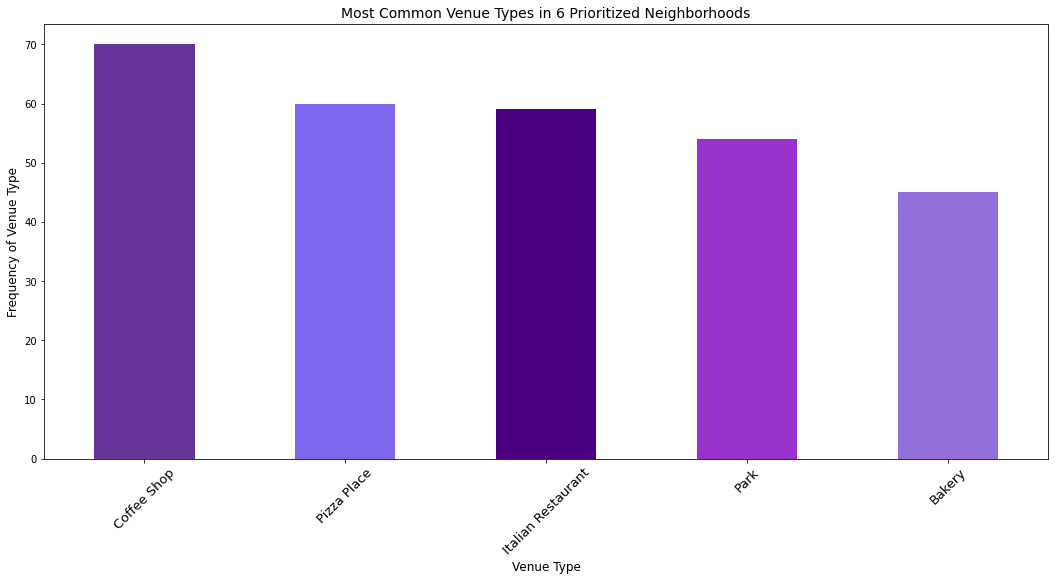

In [19]:
boston_top_venues = boston_venues.groupby(
    'Venue Category', as_index = False).count().sort_values(
    'Neighborhood', ascending = False).head(5)
boston_top_venues = boston_top_venues[['Venue Category','Neighborhood']]
boston_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
boston_top_venues.plot.bar(
    x='Venue Category', y='Frequency',
    legend=None, title="Most common venue types in 6 prioritized neighborhoods",
    rot= 45, figsize = (18, 8),
    color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])

plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in 6 Prioritized Neighborhoods', fontsize = 14)
plt.show()

In [20]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [21]:
boston_onehot.shape

(1680, 240)

#### Next, let's group rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [22]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()

# Confirm the new size:
print(boston_grouped.shape)
boston_grouped

(26, 240)


,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allston,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,Back Bay,0.000000,0.000000,0.00,0.00,0.000000,0.021978,0.000000,0.000000,0.000000,...,0.000000,0.010989,0.000000,0.000000,0.000000,0.00,0.010989,0.000000,0.010989,0.000000
2,Bay Village,0.000000,0.000000,0.00,0.00,0.000000,0.050000,0.010000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.000000,0.02,0.030000,0.000000,0.000000,0.000000
3,Beacon Hill,0.011236,0.000000,0.00,0.00,0.000000,0.044944,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.011236
4,Brighton,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
5,Charlestown,0.000000,0.000000,0.00,0.00,0.000000,0.020202,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.010101,0.00,0.000000,0.000000,0.010101,0.000000
6,Chinatown,0.000000,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.020000,0.000000,0.010000,0.000000,0.01,0.010000,0.000000,0.000000,0.000000
7,Dorchester,0.000000,0.000000,0.00,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
8,Downtown,0.010870,0.000000,0.00,0.00,0.000000,0.010870,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.021739
9,East Boston,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [23]:
num_top_venues = 5

for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
                venue  freq
0  Mexican Restaurant  0.06
1         Coffee Shop  0.06
2    Sushi Restaurant  0.05
3  Chinese Restaurant  0.05
4        Liquor Store  0.05


----Back Bay----
            venue  freq
0             Spa  0.07
1     Coffee Shop  0.05
2  Ice Cream Shop  0.03
3    Gourmet Shop  0.03
4          Bakery  0.03


----Bay Village----
                 venue  freq
0          Coffee Shop  0.05
1  American Restaurant  0.05
2   Chinese Restaurant  0.04
3   Italian Restaurant  0.04
4                  Spa  0.04


----Beacon Hill----
                 venue  freq
0       Science Museum  0.08
1            Hotel Bar  0.04
2  American Restaurant  0.04
3   Italian Restaurant  0.04
4          Pizza Place  0.04


----Brighton----
                venue  freq
0  Mexican Restaurant  0.06
1         Coffee Shop  0.06
2    Sushi Restaurant  0.05
3  Chinese Restaurant  0.05
4        Liquor Store  0.05


----Charlestown----
                 venue  freq
0       Clothing Store 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Coffee Shop,Mexican Restaurant,Sushi Restaurant,Bakery,Pizza Place,Gastropub,Chinese Restaurant,Liquor Store,Bank,Bar
1,Back Bay,Spa,Coffee Shop,Bakery,Gourmet Shop,Jewelry Store,Ice Cream Shop,Hotel Bar,Hotel,Park,Boutique
2,Bay Village,American Restaurant,Coffee Shop,Theater,Asian Restaurant,Chinese Restaurant,Spa,Italian Restaurant,Bakery,Pizza Place,Gym
3,Beacon Hill,Science Museum,Hotel Bar,American Restaurant,Pizza Place,Italian Restaurant,Gift Shop,Plaza,History Museum,Gym / Fitness Center,Ice Cream Shop
4,Brighton,Coffee Shop,Mexican Restaurant,Sushi Restaurant,Bakery,Pizza Place,Gastropub,Chinese Restaurant,Liquor Store,Bank,Bar


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [26]:
# set number of clusters
kclusters = 5

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = final_neighborhood_df

# merge boston_grouped with toronto_data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

boston_merged.head() # check the last columns!

,Neighborhood,Neighborhood_Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Roslindale,5.58,42.272,-71.1259,0,Park,Mobile Phone Shop,Train Station,Cosmetics Shop,Supermarket,Liquor Store,Donut Shop,Golf Course,Food,ATM
1,Jamaica Plain,7.62,42.3261,-71.105,1,Convenience Store,Bus Stop,Cuban Restaurant,Caribbean Restaurant,Sandwich Place,Ethiopian Restaurant,Furniture / Home Store,Supermarket,Martial Arts Dojo,Spanish Restaurant
2,Mission Hill,18.24,42.3358,-71.0904,1,Café,Art Museum,Donut Shop,Grocery Store,Pizza Place,Coffee Shop,Sandwich Place,Art Gallery,Liquor Store,Middle Eastern Restaurant
3,Longwood Medical Area,0.00,42.3367,-71.0981,1,Donut Shop,Sandwich Place,Art Museum,Café,Pizza Place,Park,Italian Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Liquor Store
4,Bay Village,0.00,42.3488,-71.0666,1,American Restaurant,Coffee Shop,Theater,Asian Restaurant,Chinese Restaurant,Spa,Italian Restaurant,Bakery,Pizza Place,Gym


#### Recognize the number of bars and restaurants in each neighborhood, and the most popular locations within those neighborhoods

In [ ]:
boston_merged["Bars and Restaurants"] = ""
boston_merged.loc[boston_merged.Neighborhood == 'Sunset/Parkside', 'Bars and Restaurants'] = .37
boston_merged.loc[boston_merged.Neighborhood == 'Outer Richmond', 'Bars and Restaurants'] = .6
boston_merged.loc[boston_merged.Neighborhood == 'Marina', 'Bars and Restaurants'] = .67
boston_merged.loc[boston_merged.Neighborhood == 'Castro/Upper Market', 'Bars and Restaurants'] = .37
boston_merged.loc[boston_merged.Neighborhood == 'West of Twin Peaks', 'Bars and Restaurants'] = .5
boston_merged.loc[boston_merged.Neighborhood == 'Hayes Valley', 'Bars and Restaurants'] = .5
boston_merged['Bars and Restaurants'].astype(int, inplace = True)

#### Finally, let's visualize the resulting clusters

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['Latitude'], boston_merged['Longitude'], boston_merged['Neighborhood'], boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## 5. Examine Clusters

Examine each cluster and determine the discriminating venue categories that
distinguish each cluster. Based on the defining categories, you can then assign a name to
each cluster. I will leave this exercise to you.

#### Cluster 1

In [29]:
boston_merged.loc[boston_merged['Cluster Labels']
                     == 0, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood_Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5.58,Park,Mobile Phone Shop,Train Station,Cosmetics Shop,Supermarket,Liquor Store,Donut Shop,Golf Course,Food,ATM
19,0.44,Park,Mobile Phone Shop,Train Station,Cosmetics Shop,Supermarket,Liquor Store,Donut Shop,Golf Course,Food,ATM


#### Cluster 2

In [30]:
boston_merged.loc[boston_merged['Cluster Labels']
                     == 1, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood_Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,7.62,Convenience Store,Bus Stop,Cuban Restaurant,Caribbean Restaurant,Sandwich Place,Ethiopian Restaurant,Furniture / Home Store,Supermarket,Martial Arts Dojo,Spanish Restaurant
2,18.24,Café,Art Museum,Donut Shop,Grocery Store,Pizza Place,Coffee Shop,Sandwich Place,Art Gallery,Liquor Store,Middle Eastern Restaurant
3,0.00,Donut Shop,Sandwich Place,Art Museum,Café,Pizza Place,Park,Italian Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Liquor Store
4,0.00,American Restaurant,Coffee Shop,Theater,Asian Restaurant,Chinese Restaurant,Spa,Italian Restaurant,Bakery,Pizza Place,Gym
5,40.92,Coffee Shop,Bakery,Chinese Restaurant,Asian Restaurant,Sandwich Place,Performing Arts Venue,Theater,Sushi Restaurant,Tea Room,American Restaurant
6,150.94,Coffee Shop,Bakery,Asian Restaurant,Chinese Restaurant,Sushi Restaurant,Sandwich Place,Theater,Historic Site,Seafood Restaurant,Tea Room
7,10.09,Italian Restaurant,Park,Harbor / Marina,Pizza Place,Café,Seafood Restaurant,Grocery Store,Hotel,Bakery,Sandwich Place
9,33.93,American Restaurant,Theater,Gym,Coffee Shop,Spa,Italian Restaurant,Pizza Place,Mexican Restaurant,Wine Bar,Wine Shop
10,20.84,Spa,Coffee Shop,Bakery,Gourmet Shop,Jewelry Store,Ice Cream Shop,Hotel Bar,Hotel,Park,Boutique
11,6.80,Sandwich Place,Liquor Store,Buffet,Big Box Store,Supermarket,Mattress Store,Metro Station,Soup Place,Food Truck,Bank


#### Cluster 3

In [31]:
boston_merged.loc[boston_merged['Cluster Labels']
                     == 2, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood_Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,0.0,Home Service,Yoga Studio,Dry Cleaner,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant


#### Cluster 4

In [32]:
boston_merged.loc[boston_merged['Cluster Labels']
                     == 3, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,Neighborhood_Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,6.37,Construction & Landscaping,Supermarket,Spanish Restaurant,Laundromat,Tennis Stadium,Discount Store,Liquor Store,Baseball Field,Pizza Place,Farmers Market
20,1.89,Construction & Landscaping,Supermarket,Spanish Restaurant,Laundromat,Tennis Stadium,Discount Store,Liquor Store,Baseball Field,Pizza Place,Farmers Market


#### Cluster 5

In [33]:
boston_merged.loc[boston_merged['Cluster Labels']
                     == 4, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]




,Neighborhood_Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,4.37,Golf Course,Accessories Store,Trail,Park,Yoga Studio,Ethiopian Restaurant,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant
